# 1. Introduction

This project is about car classification for [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split by roughly 50-50. Classes typically contain the Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

It is difficult to directly train deep learning model on this dataset because the limited number of images. Thus we decide to use transfer learning, a common approch used in deep learning to utilize the pretrained model and fine-tune on our own dataset, i.e. car dataset. A pre-trained model will be used with transfer learning to train the model. All layers will be fine tuned and the last fully connected layer will be replaced entirely.

![](https://ai.stanford.edu/~jkrause/cars/class_montage.jpg)

Dataset (196 classes):

Train folder: 8144 images, avg: 41.5 images per class.

Test folder: 8041 images, avg: 41.0 images per class.

# 2. Build the Model

## 2.1 Load Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
GeForce GTX 1070


## 2.2 Load the Data and Transform

First, lets create some transforms for our data and load the train/test data+labels from the folders.

Here we are using 224x224 images (you can also change the resolution) with random horizontal flip, random rotation and normalization

In [2]:
dataset_dir = "car_data/"

# data transformation, you can try different transformation/ data augmentation here
# note: no data augmentation for test data

width, height = 224, 224
train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                 # transforms.RandomHorizontalFlip(),
                                 # transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# create datasets
dataset = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform=train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=2)


## 2.3 Model Training Function

Here we train our model, after each epoch, we test the model on the test data to see how it's going

In [3]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):
    
    losses = []
    accuracies = []
    test_accuracies = []

    # set the model to train mode initially
    model.train()
    begin_time = time.time()
    for epoch in tqdm.tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 32 * running_correct / len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    print('Time used:',time.time() - begin_time, 's')
    return model, losses, accuracies, test_accuracies

## 2.4 Evaluate on Training Data
This function is called out after each epoch of training on the training data. We then measure the accuracy of the model.

In [4]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

# 3. Experiment

## 3.1 Define Parameters

In [5]:
NUM_CAR_CLASSES = 196

# model_ft = models.alexnet(pretrained=True)
# model_ft = models.resnet34(pretrained=True)
# model_ft = models.googlenet(pretrained=True)
# model_ft = models.resnext50_32x4d(pretrained=True)
model_ft = models.resnext101_32x8d(pretrained=True)

# Freezing model parameters and defining the fully connected network to be attached to the model, 
# loss function and the optimizer.
# We there after put the model on the GPUs
# for param in model_ft.parameters():
#     param.require_grad = False

# replace the last fc layer with an untrained one (requires grad by default)

# uncomment for alexnet
# num_ftrs = model_ft.classifier[6].in_features
# model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# uncomment for resnet34
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

model_ft = model_ft.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()


for layer in model_ft.modules():
    if isinstance(layer, nn.BatchNorm2d):
        layer.float()
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

"""
probably not the best metric to track, but we are tracking the training accuracy and measuring whether
it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the lr by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

## 3.2 Model Training

In [6]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 392 s, loss: 5.1250, acc: 1.3630


  5%|████                                                                            | 1/20 [08:24<2:39:37, 504.08s/it]

Accuracy of the network on the test images: 10 %
Epoch 2, duration: 412 s, loss: 3.1536, acc: 11.5054


 10%|████████                                                                        | 2/20 [17:08<2:33:05, 510.33s/it]

Accuracy of the network on the test images: 34 %
Epoch 3, duration: 406 s, loss: 1.8596, acc: 24.3922


 15%|████████████                                                                    | 3/20 [25:46<2:25:14, 512.60s/it]

Accuracy of the network on the test images: 47 %
Epoch 4, duration: 398 s, loss: 1.1717, acc: 32.4226


 20%|████████████████                                                                | 4/20 [34:17<2:16:32, 512.05s/it]

Accuracy of the network on the test images: 55 %
Epoch 5, duration: 401 s, loss: 0.7830, acc: 38.0833


 25%|████████████████████                                                            | 5/20 [42:49<2:07:59, 511.96s/it]

Accuracy of the network on the test images: 63 %
Epoch 6, duration: 420 s, loss: 0.5627, acc: 41.1591


 30%|████████████████████████                                                        | 6/20 [51:43<2:01:01, 518.68s/it]

Accuracy of the network on the test images: 61 %
Epoch 7, duration: 406 s, loss: 0.1627, acc: 47.6302


 35%|███████████████████████████▎                                                  | 7/20 [1:00:23<1:52:25, 518.87s/it]

Accuracy of the network on the test images: 81 %
Epoch 8, duration: 427 s, loss: 0.0631, acc: 49.2755


 40%|███████████████████████████████▏                                              | 8/20 [1:09:16<1:44:37, 523.09s/it]

Accuracy of the network on the test images: 82 %
Epoch 9, duration: 393 s, loss: 0.0430, acc: 49.5641


 45%|███████████████████████████████████                                           | 9/20 [1:17:36<1:34:40, 516.37s/it]

Accuracy of the network on the test images: 83 %
Epoch 10, duration: 393 s, loss: 0.0286, acc: 49.7114


 50%|██████████████████████████████████████▌                                      | 10/20 [1:25:58<1:25:20, 512.05s/it]

Accuracy of the network on the test images: 83 %
Epoch 11, duration: 413 s, loss: 0.0278, acc: 49.7360


 55%|██████████████████████████████████████████▎                                  | 11/20 [1:34:49<1:17:38, 517.58s/it]

Accuracy of the network on the test images: 83 %
Epoch 12, duration: 430 s, loss: 0.0214, acc: 49.8342


 60%|██████████████████████████████████████████████▏                              | 12/20 [1:43:56<1:10:11, 526.40s/it]

Accuracy of the network on the test images: 83 %
Epoch 13, duration: 401 s, loss: 0.0213, acc: 49.8342


 65%|██████████████████████████████████████████████████                           | 13/20 [1:52:24<1:00:47, 521.09s/it]

Accuracy of the network on the test images: 83 %
Epoch 14, duration: 384 s, loss: 0.0201, acc: 49.8097


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [2:00:33<51:08, 511.41s/it]

Accuracy of the network on the test images: 83 %
Epoch 15, duration: 383 s, loss: 0.0193, acc: 49.8711


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [2:08:43<42:04, 504.95s/it]

Accuracy of the network on the test images: 83 %
Epoch 16, duration: 391 s, loss: 0.0180, acc: 49.8588


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [2:17:02<33:32, 503.18s/it]

Accuracy of the network on the test images: 83 %
Epoch 17, duration: 386 s, loss: 0.0173, acc: 49.8956


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [2:25:14<24:59, 499.82s/it]

Accuracy of the network on the test images: 83 %
Epoch 18, duration: 388 s, loss: 0.0189, acc: 49.8404


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [2:33:30<16:37, 498.59s/it]

Accuracy of the network on the test images: 83 %
Epoch 19, duration: 392 s, loss: 0.0198, acc: 49.8465


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [2:41:50<08:19, 499.20s/it]

Accuracy of the network on the test images: 83 %
Epoch 20, duration: 389 s, loss: 0.0187, acc: 49.8956


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [2:50:07<00:00, 510.36s/it]

Accuracy of the network on the test images: 83 %
Finished Training
Time used: 10207.222668170929 s


In [ ]:
# records for trained models

# best testing acc for Alexnet: 37%
    # batch_size = 32
    # S-shaped learning pattern
    # learned faster during 10th-12th epoch
    
# best testing acc for resnet34: 82%
    # batch_size = 32
    # log-shaped learning pattern
    # learned faster during 1st-5th epoch
    
# best testing acc for GoogLeNet: 80%
    # batch_size = 32
    # log-shaped learning pattern
    # learned faster during 1st-3th epoch
    # starts with high acc and converges very fast
    # acc bounces in late process
    
# best testing acc for resnext101_32x8d: 83%
    # batch_size = 16
    # log-shaped learning pattern
    # learned faster during 1st-6th epoch
    # learning slows dramatically once reached bottleneck

## 3.3 Learning Process


Text(0.5, 1.0, 'Test acc')

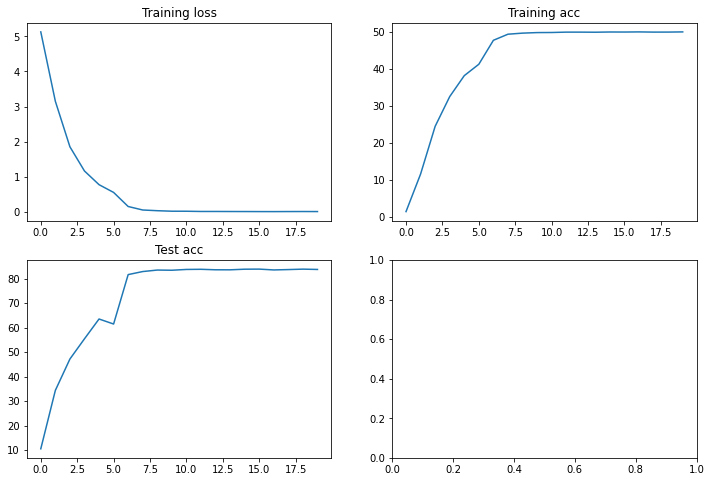

In [7]:
# plot the stats

f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

## 3.4 Evaluate the Model on Single Images

Next we can use the model on our own images. For that we need to tie the class numbers for which the model returns probablities with the names of those classes.


In [8]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

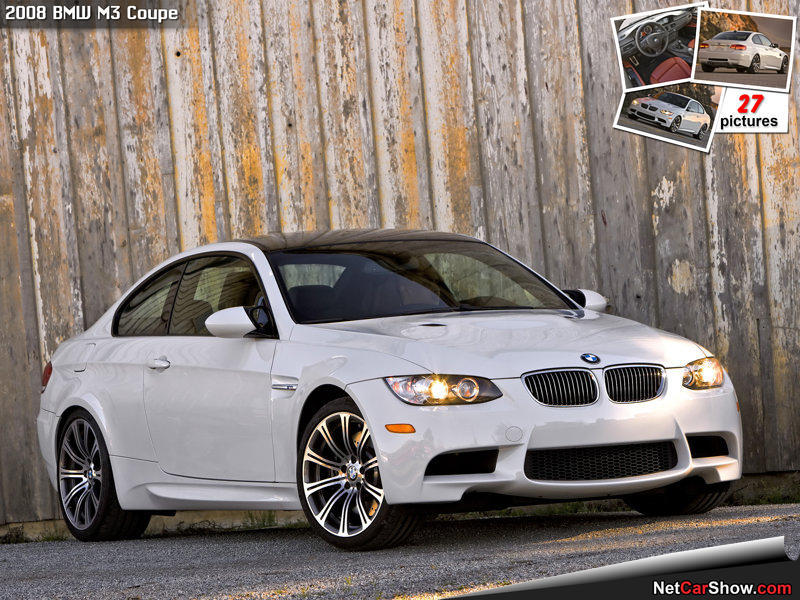

BMW M3 Coupe 2012 , confidence: 11.741933822631836


In [9]:
# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# test the model on selected image
image = Image.open(dataset_dir+"test/BMW M3 Coupe 2012/07669.jpg") # change directory here for different predictions
image_ = loader(image).float()
image_ = torch.autograd.Variable(image_, requires_grad=True)
image_ = image_.unsqueeze(0)
image_ = image_.cuda()
output = model_ft(image_)
conf, predicted = torch.max(output.data, 1)

# get the class name of the prediction
display(image)
print(classes[predicted.item()], ", confidence:", conf.item())

# 4. Save and Load Model

In [10]:
PATH = 'car_model.pth'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
model_loaded = torch.load(PATH)
model_loaded